# Train temporal convolutional encoder-decoder model

# more appropriate video-wise data selection and scaling
- reorganized into frame and population (concatenated) indices
- test run on one type of movement only - arm raise
- transformer-specific considerations for normalization (e.g. population vs. video-wise normalization)
    1. video-wise normalization to body length
    2. video-wise median filter
    3. population-wise standard scaler
        - scale left and right side body coordinates accordingly to standardize feature contribution

# load preliminaries, checkpoints

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import cv2
import yaml
import os
import sys
import glob
import pickle as pkl
import importlib
import fnmatch
from pathlib import Path
import tensorflow as tf

In [2]:
%cd ..

/Users/donwei7/Documents/code/human_motion_analysis


In [3]:
ROOT_DIR = os.getcwd()
print(ROOT_DIR)

/Users/donwei7/Documents/code/human_motion_analysis


In [7]:
# custom modules
from src.io import iomod
from src.io.utils import Config
from src.inference import inference
from src.visualization import draw
from src.analysis import analysisphysics
from src.tests import testdraw, structshape
from src.train import datatransform

# Import plotting libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection # likely limited to draw module
import matplotlib.patches as patches
import seaborn as sns

# set sns
sns.set()

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display, Image

In [8]:
# '''refactored - test later'''

# # set up paths
# CONFIG_DIR = "configs"

# def load_config(config_name):
#     with open(os.path.join(ROOT_DIR, CONFIG_DIR, config_name)) as file:
#         config = yaml.full_load(file)
#     return config

# CONFIG_KEYPOINTS = load_config(r"keypoints.yaml")
# CONFIG_EDGE_COLORS = load_config(r"edge_colors.yaml")
# PARAMS = load_config(r"analysis_parameters.yaml")

# # Confidence score to determine whether a keypoint prediction is reliable, e.g. for cropping algorithm during inference
# KEYPOINT_THRESH_SCORE_CROP = load_config('analysis_parameters.yaml')['KEYPOINT_THRESH_SCORE_CROP']

In [9]:
config = Config()
name_combinations = config.get_name_combinations()

In [10]:
df_edgenames = pd.DataFrame(name_combinations, columns=["name"])

In [11]:
query = ["nose-right_eye-start_x", "nose-right_eye-start_y"]
idx = df_edgenames.index[df_edgenames.name.isin(query)].values

In [12]:
idx

array([4, 5])

## loaded inferenced data

In [78]:
# a df of video paths and inferenced keypoints (num_frames x 17 x 3) and edges (num_frames x 18 x 2 x 2)
# out_edges is an (frame, edge-pair,  array of x-y arrays) where np.array([[x_start, y_start], [x_end, y_end]])
with open(Path(ROOT_DIR).joinpath("data", "compiled", "df_kpts"), 'rb') as f:
    df_kpts = pkl.load(f)

# cumulative edge velocities and lengths for histograms
with open(Path(ROOT_DIR).joinpath("data", "compiled", "edge_vel_all"), 'rb') as f:
    edge_vel_all = pkl.load(f)
with open(Path(ROOT_DIR).joinpath("data", "compiled", "edge_length_all"), 'rb') as f:
    edge_length_all = pkl.load(f)

In [91]:
infinity_mp4_paths = Path(ROOT_DIR).joinpath("data", "infinity").rglob("*.mp4")
infinity_armraise_mp4_paths = list(filter(lambda x: "armraise" in str(x), infinity_mp4_paths))

# remove for now jitter or bilateral swapping or other poor quality issues (visualized with x-y plots below)
remove_pattern = ["*armraise*000004.mp4", "*armraise*000005.mp4", "*armraise*000006.mp4", "*armraise*000009.mp4", "*armraise*000013.mp4", "*armraise*000018.mp4", \
  "*armraise*000019.mp4", "*armraise*000033.mp4", "*armraise*000039.mp4", "*armraise*000042.mp4", "*armraise*000044.mp4", "*armraise*000066.mp4", "*armraise*000076.mp4", "*armraise*000094.mp4", "*armraise*000097.mp4", "*armraise*000099.mp4",
  "*armraise*000025.mp4", "*armraise*000044.mp4", "*armraise*000035.mp4", "*armraise*000026.mp4", "*armraise*000020.mp4", \
  "*curl*000001.mp4", "*curl*000022.mp4", "*curl*000025.mp4", "*curl*000034.mp4", "*curl*000035.mp4", "*curl*000043.mp4", "*curl*000049.mp4", \
  "*curl*000053.mp4", "*curl*000056.mp4", "*curl*000057.mp4", "*curl*000060.mp4", "*curl*000061.mp4", "*curl*000068.mp4", "*curl*000080.mp4", \
  "*curl*000080.mp4", "*curl*000082.mp4", "*curl*000090.mp4",]

# remove from list
infinity_armraise_mp4_paths_rmv = [path for path in infinity_armraise_mp4_paths \
  if not any(fnmatch.fnmatch(path, r) for r in remove_pattern)]

# try compile edge and keypoint data, remove from paths if data unavailable
data_all, skippct, skippedpaths = iomod.compile_data(infinity_armraise_mp4_paths_rmv)
infinity_armraise_mp4_paths_rmv = [path for path in infinity_armraise_mp4_paths_rmv if path not in skippedpaths]

# some initial plots

In [159]:
match_pattern = ["*armraise*000095*"]

check_paths = [path for path in infinity_armraise_mp4_paths_rmv if any(fnmatch.fnmatch(path, r) for r in match_pattern)]

In [160]:
check_paths

[PosixPath('/Users/donwei7/Documents/code/human_motion_analysis/data/infinity/InfinityAI_InfiniteRep_armraise_v1.0/data/000095.mp4')]

In [156]:
path = str(check_paths[0])
%cp $path test_examples

In [166]:
 filename = "000077_demo"
 with open(Path("test_examples", f"{filename}_out_keypoints.pkl"), 'rb') as file:
    out_keypoints_test = pkl.load(file)

In [175]:
path = Path("test_examples", f"{filename}.gif")
samplevid = iomod.load_video(str(path))

In [110]:
path = Path(df_kpts.iloc[95].path)

'data\\infinity\\InfinityAI_InfiniteRep_armraise_v1.0\\data\\000095'

In [135]:
# make new column with string splitting to get stem
df_kpts["stem"] = df_kpts.path.apply(lambda x: x.split("\\")[-1].split(".")[0])


In [146]:
len(df_kpts.stem.values), len(df_kpts.stem.unique())

(192, 100)

In [148]:
df_kpts.stem.values

array(['000000', '000001', '000002', '000003', '000004', '000005',
       '000006', '000007', '000008', '000009', '000010', '000011',
       '000012', '000013', '000014', '000015', '000016', '000017',
       '000018', '000019', '000020', '000021', '000022', '000023',
       '000024', '000025', '000026', '000027', '000028', '000029',
       '000030', '000031', '000032', '000033', '000034', '000035',
       '000036', '000037', '000038', '000039', '000040', '000041',
       '000042', '000043', '000044', '000045', '000046', '000047',
       '000048', '000049', '000050', '000051', '000052', '000053',
       '000054', '000055', '000056', '000057', '000058', '000059',
       '000060', '000061', '000062', '000063', '000064', '000065',
       '000066', '000067', '000068', '000069', '000070', '000071',
       '000072', '000073', '000074', '000075', '000076', '000077',
       '000078', '000079', '000080', '000081', '000082', '000083',
       '000084', '000085', '000086', '000087', '000088', '0000

In [147]:
df_kpts.stem.unique()

array(['000000', '000001', '000002', '000003', '000004', '000005',
       '000006', '000007', '000008', '000009', '000010', '000011',
       '000012', '000013', '000014', '000015', '000016', '000017',
       '000018', '000019', '000020', '000021', '000022', '000023',
       '000024', '000025', '000026', '000027', '000028', '000029',
       '000030', '000031', '000032', '000033', '000034', '000035',
       '000036', '000037', '000038', '000039', '000040', '000041',
       '000042', '000043', '000044', '000045', '000046', '000047',
       '000048', '000049', '000050', '000051', '000052', '000053',
       '000054', '000055', '000056', '000057', '000058', '000059',
       '000060', '000061', '000062', '000063', '000064', '000065',
       '000066', '000067', '000068', '000069', '000070', '000071',
       '000072', '000073', '000074', '000075', '000076', '000077',
       '000078', '000079', '000080', '000081', '000082', '000083',
       '000084', '000085', '000086', '000087', '000088', '0000

In [104]:
%cp $path .

cp: datainfinityInfinityAI_InfiniteRep_armraise_v1.0data000095.mp4: No such file or directory


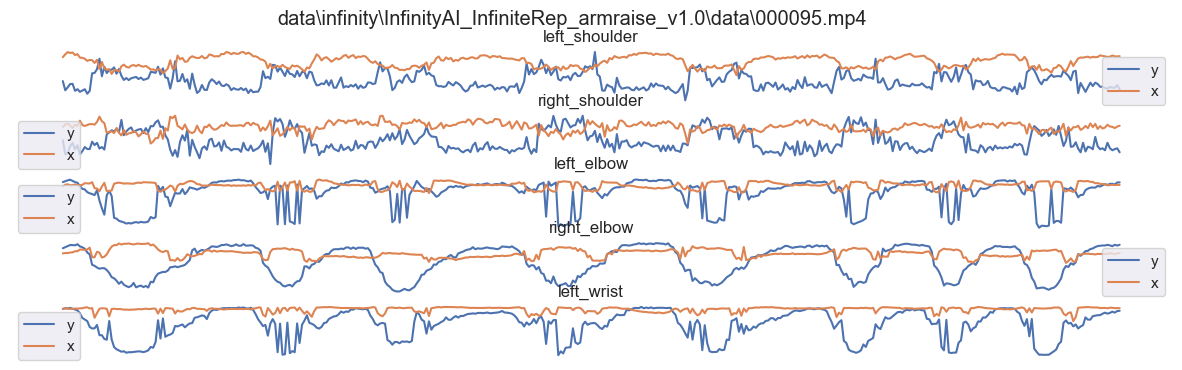

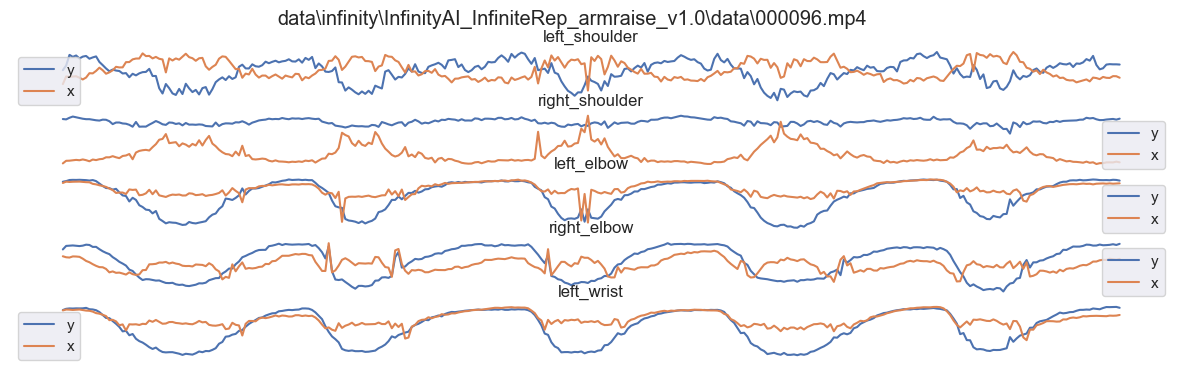

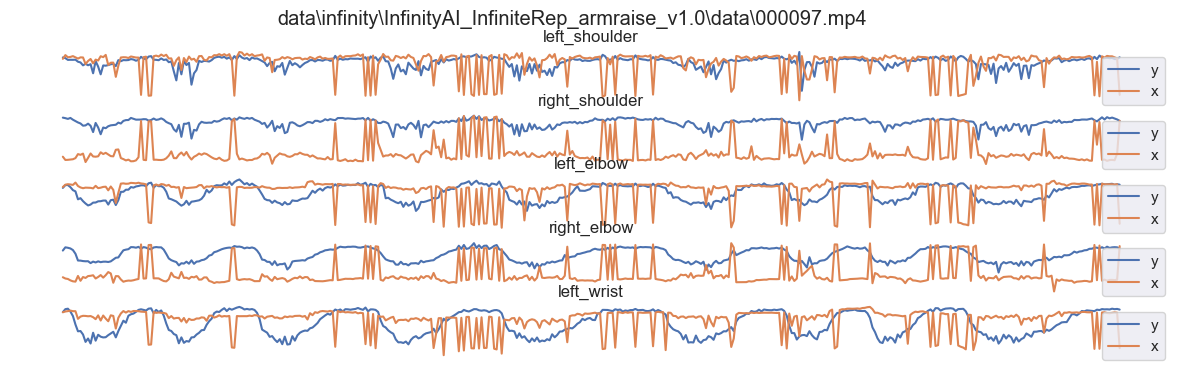

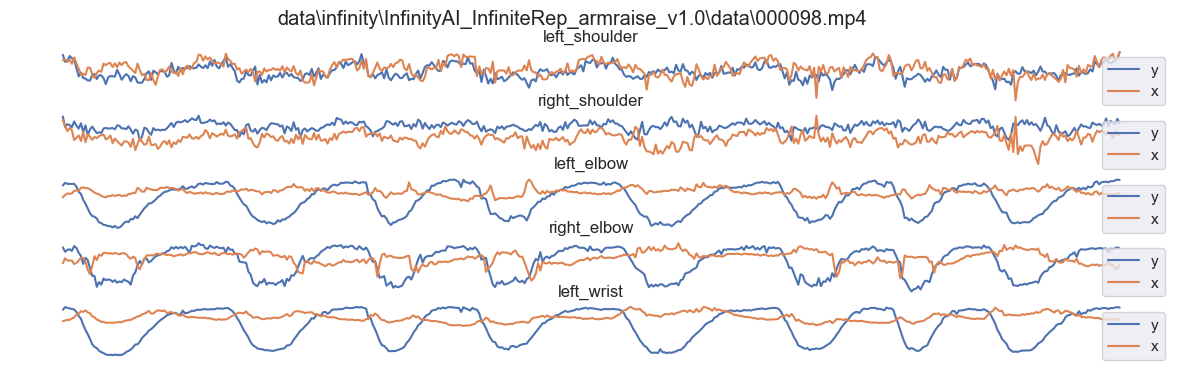

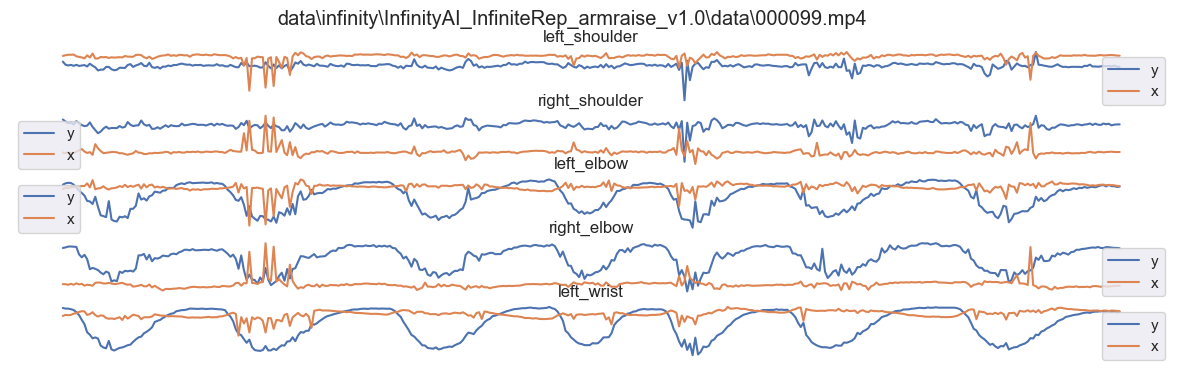

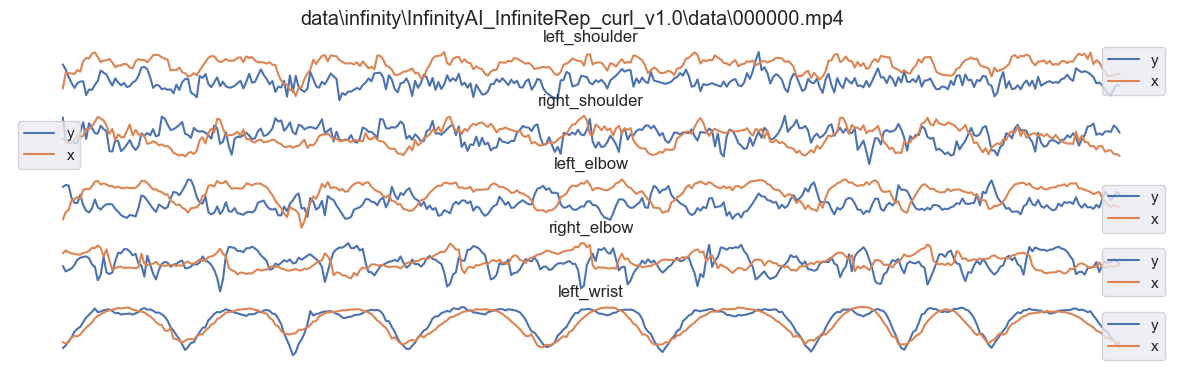

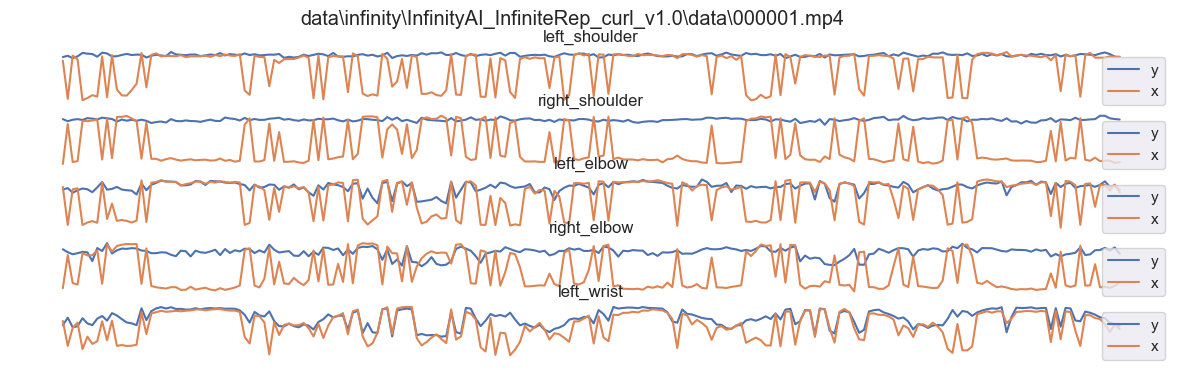

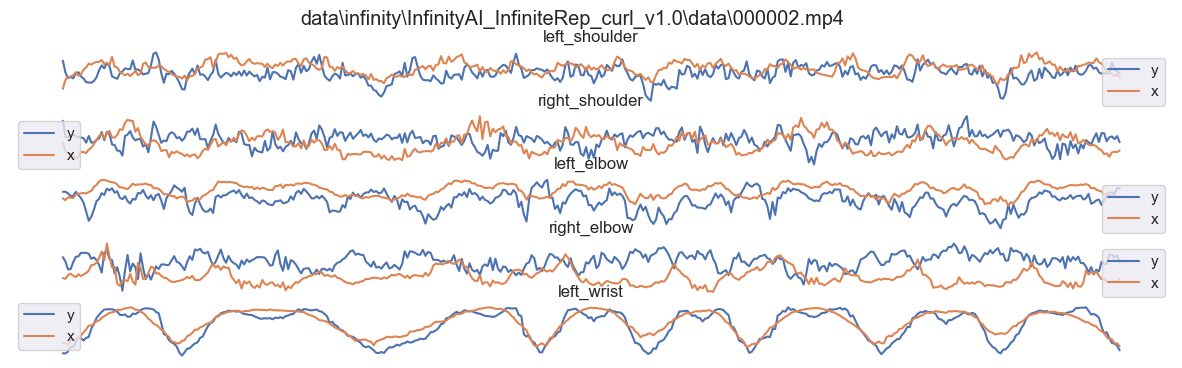

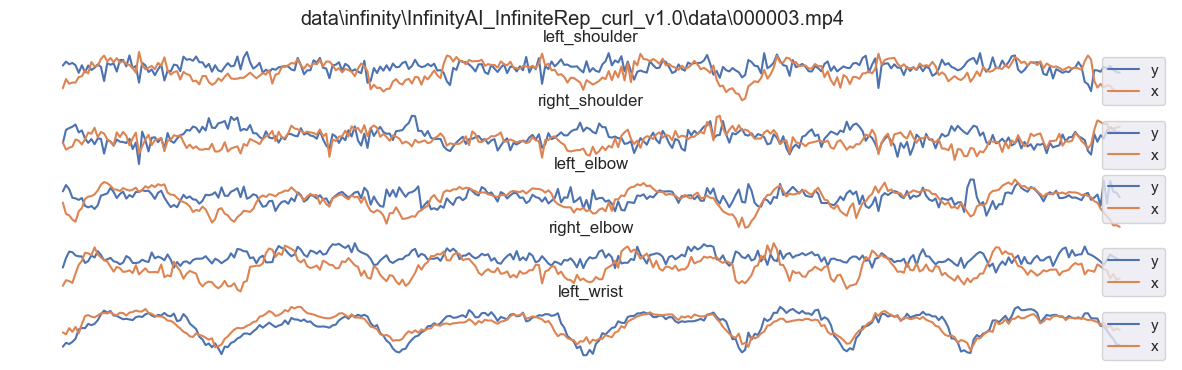

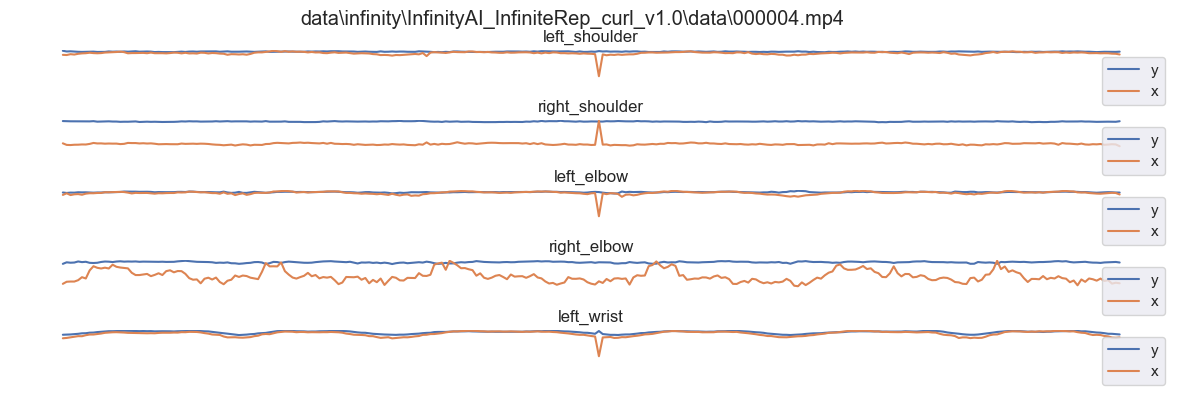

In [95]:
# plot peak normalized x-y coordinates of relevant upper torso keypoints
num_kpts = 17
analyze_pathidx = range(95, 105)
analyze_kptsidx = range(5, 10)
num_paths = len(df_kpts.out_keypoints)

for pathidx in analyze_pathidx:
  plt.figure(figsize=(15, 4))
  plt.suptitle(df_kpts.loc[pathidx, 'path'])
    
  # fr, 17, 3
  for subi, i in enumerate(analyze_kptsidx):
    plt.subplot(5, 1, subi+1)
    plt.plot(np.arange(len(df_kpts.out_keypoints[pathidx])), df_kpts.out_keypoints[pathidx][:,i,0] / np.max(df_kpts.out_keypoints[pathidx][:,i,0]))
    plt.plot(np.arange(len(df_kpts.out_keypoints[pathidx])), df_kpts.out_keypoints[pathidx][:,i,1] / np.max(df_kpts.out_keypoints[pathidx][:,i,1]))
    plt.title(f"{list(config.kpts)[i]}")
    plt.axis('off')
    plt.legend(['y', 'x'])
  
plt.subplots_adjust(hspace=1.5)
plt.rcParams.update({'font.size': 10})

# data selection and scaling

In [546]:
# create features df over train paths
df_edge_features_train_idx = pd.DataFrame(columns=["path"]+name_combinations)

# create features df over paths
for path in train_paths:
  # flatten to 2-D with combinations of edge-pair-xy features as above
  data = data_all["out_edges"][path][:, :, :, :].reshape(-1, 72).astype('float32')
  df = pd.DataFrame(data, columns=name_combinations)

  # left merge with path
  df_path = pd.DataFrame(index=np.arange(len(df)), columns=['path'])
  df_path = df_path.assign(path=path)
  df_merged = pd.merge(df_path, df, left_index=True, right_index=True)

  # vertcat
  df_edge_features_train_idx = pd.concat([df_edge_features_train_idx, df_merged])

df_edge_features_train_idx.reset_index(inplace=True)
df_edge_features_train_idx = df_edge_features_train_idx.rename(columns = {'index':'frame'})
df_edge_features_train_idx

,frame,path,nose-left_eye-start_x,nose-left_eye-start_y,nose-left_eye-end_x,nose-left_eye-end_y,nose-right_eye-start_x,nose-right_eye-start_y,nose-right_eye-end_x,nose-right_eye-end_y,...,right_hip-right_knee-end_x,right_hip-right_knee-end_y,left_knee-left_ankle-start_x,left_knee-left_ankle-start_y,left_knee-left_ankle-end_x,left_knee-left_ankle-end_y,right_knee-right_ankle-start_x,right_knee-right_ankle-start_y,right_knee-right_ankle-end_x,right_knee-right_ankle-end_y
0,0,data\infinity\InfinityAI_InfiniteRep_armraise_...,75.665298,101.75737,76.976624,99.817284,75.665298,101.75737,73.683929,100.251495,...,69.851334,165.69545,78.69207,164.616486,78.428467,185.893784,69.851334,165.69545,70.221771,188.035339
1,1,data\infinity\InfinityAI_InfiniteRep_armraise_...,74.830048,99.765633,76.675888,97.546959,74.830048,99.765633,72.672455,97.33902,...,69.625862,166.102692,80.575333,165.411819,80.911613,185.946487,69.625862,166.102692,69.977905,186.610779
2,2,data\infinity\InfinityAI_InfiniteRep_armraise_...,74.881653,100.465057,77.061043,98.10257,74.881653,100.465057,72.948944,97.957253,...,69.869415,166.283279,80.761185,165.856995,79.739555,186.465347,69.869415,166.283279,69.529907,186.951019
3,3,data\infinity\InfinityAI_InfiniteRep_armraise_...,74.708275,100.350304,76.778374,97.915443,74.708275,100.350304,72.593353,97.912682,...,69.888512,165.69812,81.029114,164.800018,79.526077,186.013596,69.888512,165.69812,69.56575,186.710022
4,4,data\infinity\InfinityAI_InfiniteRep_armraise_...,74.744034,100.471191,76.635597,98.269859,74.744034,100.471191,72.696358,98.048141,...,69.924309,165.469925,81.001511,164.782578,79.572372,185.901123,69.924309,165.469925,70.093231,186.904419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21883,436,data\infinity\InfinityAI_InfiniteRep_armraise_...,77.269882,93.597839,80.85051,90.790474,77.269882,93.597839,74.756706,91.055351,...,75.403091,199.039413,88.198685,198.52774,91.90834,224.077606,75.403091,199.039413,76.234848,224.789474
21884,437,data\infinity\InfinityAI_InfiniteRep_armraise_...,77.335716,93.490814,80.846809,90.776741,77.335716,93.490814,74.805122,91.061043,...,75.215744,198.381317,88.221115,197.884659,91.789871,223.283356,75.215744,198.381317,76.022743,223.705948
21885,438,data\infinity\InfinityAI_InfiniteRep_armraise_...,77.444847,93.724792,81.037727,90.85144,77.444847,93.724792,74.774712,91.090515,...,75.061768,198.447861,87.720444,198.452866,91.687416,222.219284,75.061768,198.447861,76.295067,223.292618
21886,439,data\infinity\InfinityAI_InfiniteRep_armraise_...,77.177231,93.702003,80.814651,90.966919,77.177231,93.702003,74.734482,91.066818,...,74.55632,197.45871,87.567856,197.70636,90.699448,222.462296,74.55632,197.45871,75.415688,222.251343


### add paths as column and split data

In [92]:
from sklearn.model_selection import train_test_split

def compile_data(data_all, paths, name_combinations=name_combinations):
  # create features df over train paths
  df_features = pd.DataFrame(columns=["path"]+name_combinations)
  # print(f"{df_features=}", structshape.getshape(df_features))

  # create features df over paths
  for path in paths:
    # flatten to 2-D with combinations of edge-pair-xy features as above
    data = data_all["out_edges"][path][:, :, :, :].reshape(-1, 72).astype('float32')
    df = pd.DataFrame(data, columns=name_combinations)

    # left merge with path
    df_path = pd.DataFrame(index=np.arange(len(df)), columns=['path'])
    df_path = df_path.assign(path=path)
    df_merged = pd.merge(df_path, df, left_index=True, right_index=True)
    # print(f"{df_merged=}", structshape.getshape(df_merged))

    # cumulatively append
    df_features = pd.concat([df_features, df_merged])
    # print(f"{df_features=}", structshape.getshape(df_features))

  df_features.reset_index(inplace=True)
  df_features = df_features.rename(columns = {'index':'frame'})

  return df_features


def compile_split_data(data_all, all_paths, name_combinations=name_combinations):
  train_paths, test_paths = train_test_split(all_paths, test_size=0.2)
  train_paths, val_paths = train_test_split(train_paths, test_size=0.2)

  train_df = compile_data(data_all, train_paths, name_combinations)
  val_df = compile_data(data_all, val_paths, name_combinations)
  test_df = compile_data(data_all, test_paths, name_combinations)

  return train_df, val_df, test_df


train_df, val_df, test_df = compile_split_data(data_all, infinityds_mp4paths_armmotion_rmv, name_combinations)

NameError: name 'infinityds_mp4paths_armmotion_rmv' is not defined

can keep input df like this, then keep only absolute indices and values needed for pipeline, with essentially unique identifier for each frame in case need to look at frames individually later

In [577]:
import importlib
importlib.reload(datatransform)

# make various pipelines and wrap with model to test
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# columns to select for downstream processing
select_colnames = ['right_elbow-right_wrist-start_x', 'left_elbow-left_wrist-start_x']

# columns to select for normalization via body length
head_colnames = ['nose-right_eye-start_y', 'nose-left_eye-start_y'] 
feet_colnames = ['right_knee-right_ankle-end_y', 'left_knee-left_ankle-end_y']

row_indices_enumerated = datatransform.get_indices(df_edge_features_train_idx)

feature_transformer_idx = datatransform.NormalizeDistanceBodyLength(select_colnames, head_colnames, feet_colnames, row_indices_enumerated)
med_filter = datatransform.MedFilter(row_indices_enumerated)

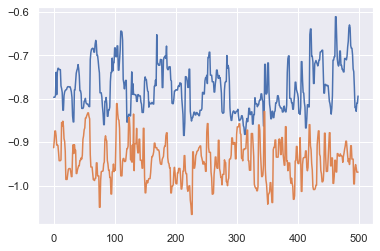

In [578]:
preprocess_pipe = Pipeline([
    ('selector_normalizer', feature_transformer_idx), # video-wise normlization to body length
    ('median_filter', med_filter), # video-wise median filter
    ('scaler', StandardScaler()), # population-wise standard scaler

])

train_data = preprocess_pipe.fit_transform(train_df)
plt.plot(train_data[:500])

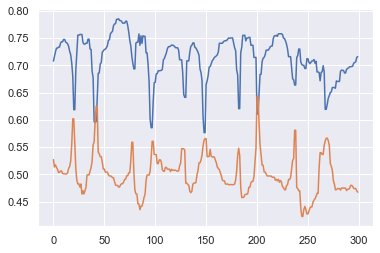

In [586]:
# same as above but for test set
row_indices_enumerated_test = datatransform.get_indices(test_df)
feature_transformer_test = datatransform.NormalizeDistanceBodyLength(select_colnames, head_colnames, feet_colnames, row_indices_enumerated_test)
med_filter_test = datatransform.MedFilter(row_indices_enumerated_test)

preprocess_pipe_test = Pipeline([
    ('selector_normalizer', feature_transformer_test), # video-wise normlization to body length
    ('median_filter', med_filter_test), # video-wise median filter
    ('scaler', StandardScaler()), # population-wise standard scaler

])

test_data = preprocess_pipe_test.fit_transform(test_df)
plt.plot(test_data[2300:2600])

# create sequences
**rest of notebook work in progress - copied from previous naive approach as template.

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

TIME_STEPS = 128

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [13]:
# pose data
x_train_pose = create_sequences(df_edge_features_train.iloc[:,48].values.reshape(-1, 1))
x_test_pose = create_sequences(df_edge_features_test.iloc[:,48].values.reshape(-1, 1))
x_val_pose = create_sequences(df_edge_features_val.iloc[:,48].values.reshape(-1, 1))

In [85]:
# save
with open(r'data\compiled\x_train_90fr_armraise.pkl', 'wb') as f:
  pkl.dump(x_train_pose, f)

<AxesSubplot:>

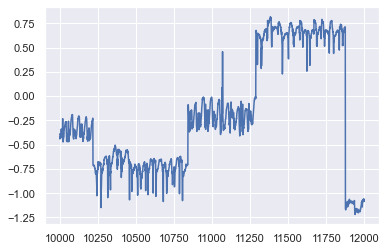

In [86]:
df_edge_features_train.iloc[10000:12000,48].plot()

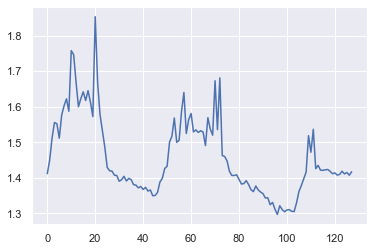

In [87]:
plt.plot(x_train_pose[4,:,:])

In [17]:
x_train_pose.shape

(22835, 128, 1)

# test train (optional)

In [89]:
# pose - optional train
model = keras.Sequential(
    [
        layers.Input(shape=(x_train_pose.shape[1], x_train_pose.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 64, 32)            256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 64, 32)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 32, 16)            3600      
_________________________________________________________________
conv1d_transpose_9 (Conv1DTr (None, 64, 16)            1808      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64, 16)            0         
_________________________________________________________________
conv1d_transpose_10 (Conv1DT (None, 128, 32)           3616      
_________________________________________________________________
conv1d_transpose_11 (Conv1DT (None, 128, 1)           

In [81]:
# save model as template for training script
model.save(r'models/templates/1convd_5layers_90fr.h5')

In [24]:
history = model.fit(
    x_train_pose,
    x_train_pose,
    epochs=1,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

278/278 [==============================] - 20s 6ms/step - loss: 0.0889 - val_loss: 0.0264


# evaluate

above can be done using training script. checkpoint from saved files in models dir

In [19]:
# load model
model = keras.models.load_model(r'models\2022-06-06_21-06-54\model.h5')

In [ ]:
# load history
with open(r'data\compiled\history_90fr_armraise.pkl', 'rb') as f:
  history = pkl.load(f)

In [ ]:
# pose
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [33]:
import datetime
now = datetime.datetime.now()
time_stamp = now.strftime("%Y-%m-%d_%H-%M-%S")
OUT_DIR = os.path.join(os.getcwd(), 'models', time_stamp)

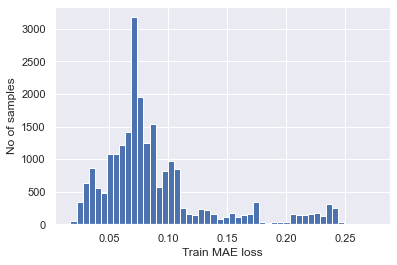

Reconstruction error threshold:  0.2755073208460751


In [26]:
# pose get MAE loss & threshold (max)
# note threshold drawn from training data, to be used on test data
x_train_pred_pose = model.predict(x_train_pose)
train_mae_loss_pose = np.mean(np.abs(x_train_pred_pose - x_train_pose), axis=1)

plt.hist(train_mae_loss_pose, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold_pose = np.max(train_mae_loss_pose) 
print("Reconstruction error threshold: ", threshold_pose)

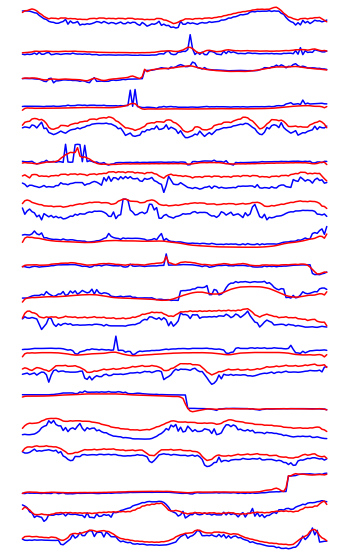

In [28]:
# pose - check train
plot_idxs = range(0, 20000, 1000)
subplot_idxs = [i + 1 for i in range(len(plot_idxs))]
x_train_pred_pose = model.predict(x_train_pose)

figure = plt.figure(figsize=(6,10))
for si, pi in zip(subplot_idxs, plot_idxs):
  plt.subplot(len(subplot_idxs),1, si)
  # plot_idx = plot_idxs[pi]
  plt.plot(x_train_pose[pi], color='blue')
  plt.plot(x_train_pred_pose[pi], color='red')
  plt.axis('off')


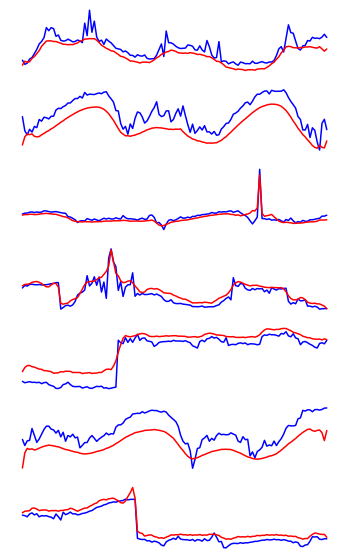

In [30]:
# pose - check test set
plot_idxs = range(0, 7000, 1000)
subplot_idxs = [i + 1 for i in range(len(plot_idxs))]
x_test_pred_pose = model.predict(x_test_pose)

figure = plt.figure(figsize=(6,10))
for si, pi in zip(subplot_idxs, plot_idxs):
  plt.subplot(len(subplot_idxs),1, si)
  # plot_idx = plot_idxs[pi]
  plt.plot(x_test_pose[pi], color='blue')
  plt.plot(x_test_pred_pose[pi], color='red')
  plt.axis('off')


Text(0, 0.5, 'No of samples')

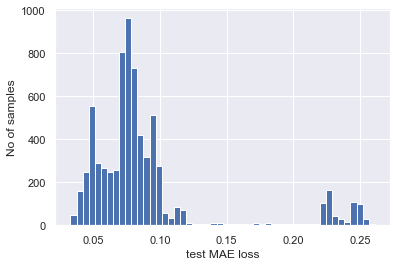

In [31]:
# pose
test_mae_loss_pose = np.mean(np.abs(x_test_pred_pose - x_test_pose), axis=1)
test_mae_loss_pose = test_mae_loss_pose.reshape((-1))

plt.hist(test_mae_loss_pose, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")

In [48]:
threshold_pose = 0.18

# Detect all the samples which are anomalies_pose.
anomalies_pose = test_mae_loss_pose > threshold_pose
print("Number of anomaly samples: ", np.sum(anomalies_pose))

Number of anomaly samples:  115


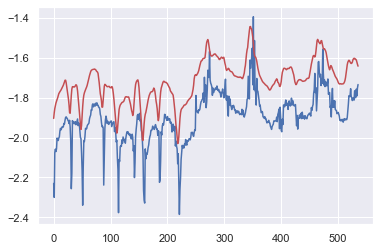

In [33]:
# pose
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices_pose = []
for data_idx in range(TIME_STEPS - 1, len(x_test_pose) - TIME_STEPS + 1):
    if np.all(anomalies_pose[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices_pose.append(data_idx)

plt.plot(x_test_pose[anomalous_data_indices_pose, 0, 0], color='b')
plt.plot(x_test_pred_pose[anomalous_data_indices_pose, 0, 0], color="r")
# plot all MAE > 0.18

In [ ]:
anomalous_data_indices_pose

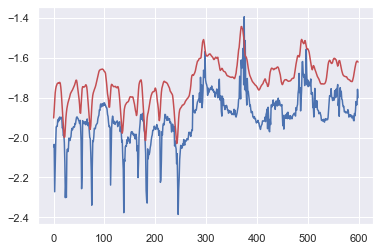

In [42]:
plt.plot(x_test_pose[3400:4000, 0, 0], color='b')
plt.plot(x_test_pred_pose[3400:4000, 0, 0], color="r")
# 287:664 have MAE > 0.18

perhaps some indication that this movement should be less exaggerated

seems to be some indication that model corrects toward baseline in both directions - promising

# random tests on other joints

In [ ]:
# pose - test on other joint positions (only trained on one joint)

analyze_jt_idx = range(36, 52)
plot_idxs = range(0, 7000, 1000)
MAE_cum = []

for jt_idx in analyze_jt_idx:

  x_test_pose = create_sequences(df_edge_features_test.iloc[:,jt_idx].values.reshape(-1, 1))
  x_test_pred_pose = model.predict(x_test_pose)

  subplot_idxs = [i + 1 for i in range(len(plot_idxs))]

  fig1 = plt.figure(figsize=(6,10))
  fig1.suptitle(name_combinations[jt_idx])

  for si, pi in zip(subplot_idxs, plot_idxs):
    plt.subplot(len(subplot_idxs),1, si)
    plt.plot(x_test_pose[pi], color='blue')
    plt.plot(x_test_pred_pose[pi], color='red')
    plt.axis('off')

  fig2 = plt.figure(figsize=(5,2))
  fig2.suptitle(name_combinations[jt_idx])

  # Get test MAE loss.
  test_mae_loss_pose = np.mean(np.abs(x_test_pred_pose - x_test_pose), axis=1)
  test_mae_loss_pose = test_mae_loss_pose.reshape((-1))

  plt.hist(test_mae_loss_pose, bins=50)
  plt.xlabel("test MAE loss")
  plt.ylabel("No of samples")

  MAE_cum.append(test_mae_loss_pose)

plt.boxplot(name_combinations[analyze_jt_idx], MAE_cum)
plt.xlabel("joint")
plt.title("MAE")

Text(0.5, 0, 'MAE')

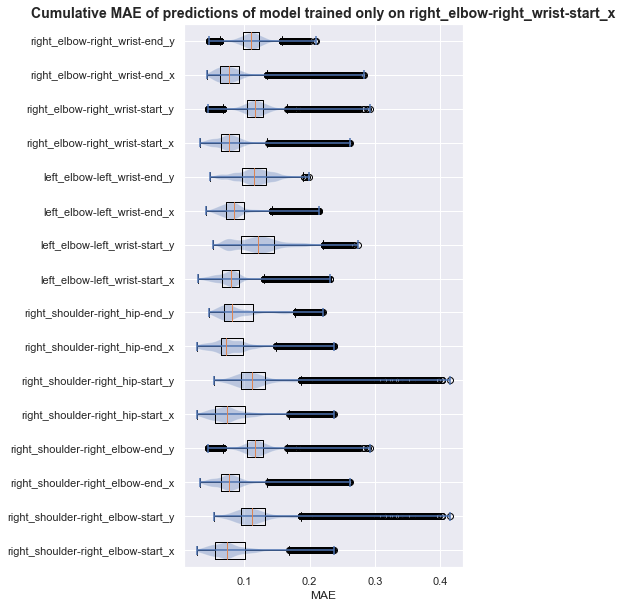

In [46]:
from operator import itemgetter

# plot MAE for all
fig = plt.figure(figsize=(5,10))
plt.boxplot(MAE_cum, labels=list(itemgetter(*analyze_jt_idx)(name_combinations)), vert=False)
plt.violinplot(MAE_cum, vert=False)

plt.title("Cumulative MAE of predictions of model trained only on right_elbow-right_wrist-start_x", fontsize=14, fontweight='bold')
plt.xlabel("MAE")


evaluate on test video w/ less % range of motion

In [ ]:
# copied from test_synthetic_data.ipynb - refactor later

import tensorflow_hub as hub
MODEL_NAME = config.params["MODEL_NAME"]

if "tflite" in MODEL_NAME:
  if "movenet_lightning_f16" in MODEL_NAME:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in MODEL_NAME:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in MODEL_NAME:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in MODEL_NAME:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % MODEL_NAME)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in MODEL_NAME:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in MODEL_NAME:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % MODEL_NAME)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores
    


test_path = r"C:\MLprojects\human_motion_analysis\data\infinity\armraise_generated\video.rgb.mp4"
samplevid = iomod.load_video(test_path)

# # Make a gif and save
fgifpath = f"{test_path}_test_thunder4.gif"
iomod.imageio.mimsave(fgifpath, samplevid)

# Read & decode from saved file
imagesgif = tf.io.read_file(fgifpath)
images = tf.image.decode_gif(imagesgif)

# Run inference
out_keypoints, out_edges = \
    inference.inference_video(movenet, images, input_size, \
                              config.kpts, config.edges, config.params['KEYPOINT_THRESH_SCORE_CROP'], config.params)

# save for later collection downstream
with open(f"{test_path}_out_keypoints.pkl", 'wb') as f:
  pkl.dump(out_keypoints, f)
with open(f"{test_path}_out_edges.pkl", 'wb') as f:
  pkl.dump(out_edges, f)

print("Processed inference:", fgifpath)

# Get mask for labeling edges based on velocity
mask_edge = analysisphysics.compute_edge_velocities(out_edges, config.params["EDGE_VEL_THRESH"])


output_images, output_images2 = \
    draw.wrap_draw_subplots(images, out_keypoints, out_edges, config.edges, \
                            mask_edge=mask_edge, figsize=(10,10))


# Prepare gif visualization.
output2 = np.stack(output_images2, axis=0)
iomod.convert_to_gif(output2, fgifpath, fps=20)

print("Processed & Saved gif to", fgifpath)

In [55]:
test_dir = r"C:\MLprojects\human_motion_analysis\data\infinity\armraise_generated"
# open edges pkl
with open(os.path.join(test_dir, "video.rgb.mp4_out_edges.pkl"), 'rb') as f:
  out_edges = pkl.load(f)

out_edges

array([[[[ 96.75950623,  76.67672729],
         [100.50276184,  76.04159546]],

        [[ 96.75950623,  76.67672729],
         [ 93.42636108,  75.11966705]],

        [[ 96.75950623,  76.67672729],
         [114.13893127, 101.0453949 ]],

        ...,

        [[ 84.93815613, 150.82917786],
         [ 85.41940308, 197.8868103 ]],

        [[106.74842072, 198.66345215],
         [107.69525146, 219.52294922]],

        [[ 85.41940308, 197.8868103 ],
         [ 84.96187592, 217.65820312]]],


       [[[ 96.70571899,  77.35492706],
         [100.02918243,  76.37657928]],

        [[ 96.70571899,  77.35492706],
         [ 93.07086182,  75.93089294]],

        [[ 96.70571899,  77.35492706],
         [113.54869843, 102.07250977]],

        ...,

        [[ 84.26352692, 151.213974  ],
         [ 85.35119629, 198.69670105]],

        [[106.55154419, 199.93873596],
         [108.27056122, 215.89826965]],

        [[ 85.35119629, 198.69670105],
         [ 85.07049561, 222.86260986]]],


       [

In [64]:
# copied
path = test_path
df_edge_features_halfROM = pd.DataFrame(columns=["path"]+name_combinations)

# flatten to 2-D with combinations of edge-pair-xy features as above
data = out_edges[:, :, :, :].reshape(-1, 72).astype('float32')
df = pd.DataFrame(data, columns=name_combinations)

# left merge with path
df_path = pd.DataFrame(index=np.arange(len(df)), columns=['path'])
df_path = df_path.assign(path=path)
df_merged = pd.merge(df_path, df, left_index=True, right_index=True)

# vertcat
df_edge_features_halfROM = pd.concat([df_edge_features_halfROM, df_merged])


df_edge_features_halfROM = df_edge_features_halfROM[name_combinations].astype(float).apply(stats.zscore)

<AxesSubplot:ylabel='Frequency'>

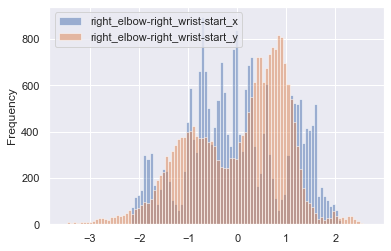

In [82]:
df_edge_features_train.iloc[:,48:50].plot(kind='hist', bins=100, alpha=0.5)

In [65]:
df_edge_features_halfROM

,nose-left_eye-start_x,nose-left_eye-start_y,nose-left_eye-end_x,nose-left_eye-end_y,nose-right_eye-start_x,nose-right_eye-start_y,nose-right_eye-end_x,nose-right_eye-end_y,nose-left_shoulder-start_x,nose-left_shoulder-start_y,...,right_hip-right_knee-end_x,right_hip-right_knee-end_y,left_knee-left_ankle-start_x,left_knee-left_ankle-start_y,left_knee-left_ankle-end_x,left_knee-left_ankle-end_y,right_knee-right_ankle-start_x,right_knee-right_ankle-start_y,right_knee-right_ankle-end_x,right_knee-right_ankle-end_y
0,-0.670465,-2.967244,2.494415,-1.995886,-0.670465,-2.967244,0.122285,-3.454333,-0.670465,-2.967244,...,0.764626,-3.957323,-1.725692,-3.135345,-1.460654,0.371475,0.764626,-3.957323,0.148102,-7.054759
1,-0.996456,-1.513480,-0.786750,-1.017577,-0.996456,-1.513480,-1.762224,-0.828431,-0.996456,-1.513480,...,0.478179,-2.192103,-2.565605,-1.389680,0.368027,-1.558953,0.478179,-2.192103,0.496524,1.837685
2,-1.323279,-2.290822,-0.870004,-1.840005,-1.323279,-2.290822,-1.550987,-1.800861,-1.323279,-2.290822,...,0.823133,-1.826767,-3.731197,-3.432816,-0.400772,-1.864128,0.823133,-1.826767,1.535233,-0.346005
3,-0.258375,-1.585307,0.511645,-1.016953,-0.258375,-1.585307,-1.020853,-1.035112,-0.258375,-1.585307,...,0.184490,-1.182964,-2.169360,-2.143802,0.113248,0.646493,0.184490,-1.182964,-0.291948,0.333946
4,-0.162288,-1.771056,0.428602,-1.507946,-0.162288,-1.771056,-0.721611,-1.669231,-0.162288,-1.771056,...,0.723805,-0.357075,-3.091523,-2.167341,-0.154529,0.682510,0.723805,-0.357075,0.073288,0.584573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0.742488,0.605405,0.279432,1.256394,0.742488,0.605405,1.859093,0.877642,0.742488,0.605405,...,-0.217176,0.046108,-0.006580,0.059265,0.347051,-0.071159,-0.217176,0.046108,0.429150,0.549168
131,-1.022813,1.466219,0.081472,1.164261,-1.022813,1.466219,-0.155765,1.145742,-1.022813,1.466219,...,0.216563,-1.793975,0.648360,0.414384,-1.657037,0.090558,0.216563,-1.793975,0.616516,0.970487
132,-1.217298,1.433511,-0.163375,0.346266,-1.217298,1.433511,-0.122642,0.416790,-1.217298,1.433511,...,0.139505,-0.201562,0.357930,0.611765,-1.496157,0.245466,0.139505,-0.201562,-0.012294,0.178480
133,0.190846,-0.398458,0.091462,-0.992466,0.190846,-0.398458,-1.234597,-0.028651,0.190846,-0.398458,...,0.778019,-0.243367,0.023300,-0.530769,-0.993292,0.894043,0.778019,-0.243367,0.064575,0.491393


<AxesSubplot:ylabel='Frequency'>

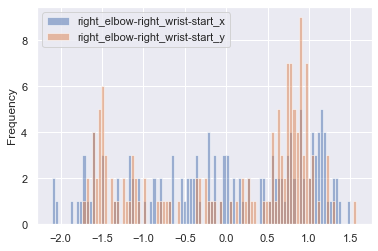

In [83]:
df_edge_features_halfROM.iloc[:,48:50].plot(kind='hist', bins=100, alpha=0.5)

<AxesSubplot:>

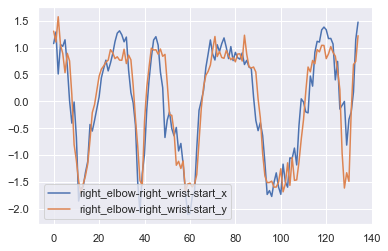

In [78]:
df_edge_features_halfROM.iloc[:,48:50].plot()

In [71]:
x_test_pose_halfROM = create_sequences(df_edge_features_halfROM.iloc[:,49].values.reshape(-1, 1))

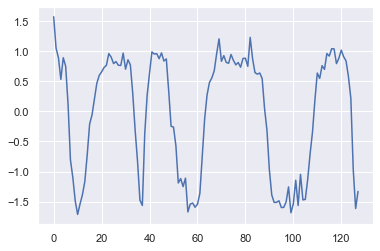

In [76]:
plt.plot(x_test_pose_halfROM[2,:,:])

In [73]:
x_test_pose_halfROM.shape

(8, 128, 1)

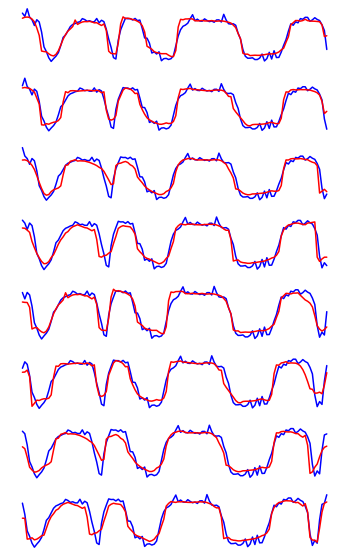

In [74]:
# pose - check train
plot_idxs = range(0, 8)
subplot_idxs = [i + 1 for i in range(len(plot_idxs))]
x_test_pose_pred_halfROM = model.predict(x_test_pose_halfROM)

figure = plt.figure(figsize=(6,10))
for si, pi in zip(subplot_idxs, plot_idxs):
  plt.subplot(len(subplot_idxs),1, si)
  # plot_idx = plot_idxs[pi]
  plt.plot(x_test_pose_halfROM[pi], color='blue')
  plt.plot(x_test_pose_pred_halfROM[pi], color='red')
  plt.axis('off')
